# PV China 2020 Dataset

This dataset maps the distribution of photovoltaic (PV) solar power installations across China as of *2020*. It was generated using a pixel-based **Random Forest classifier** applied to **Landsat 8 Surface Reflectance** products, with all processing conducted on **Google Earth Engine (GEE)**.

This dataset and its methodology are described in the following paper:

> **Huang, Y., Liu, J., Xu, Y. et al. (2022)**  
> *A high-resolution inventory of photovoltaic power installations in China.*  
> *Earth System Science Data*, **14**, 2839–2854.  
> [https://doi.org/10.5194/essd-14-2839-2022](https://doi.org/10.5194/essd-14-2839-2022)

The dataset is publicly available on **Zenodo**:
> [PV_China_2020 on Zenodo (Record #6849477)](https://zenodo.org/record/6849477)

# Setup

In [6]:
import os
import zipfile
import requests
import geopandas as gpd

## Download

In [ ]:
url = "https://zenodo.org/record/6849477/files/PV_China_2020.zip?download=1"

# Output folder
output_folder = os.path.join("..", "..", "data", "raw_data", "pv_china_2020")
os.makedirs(output_folder, exist_ok=True)

zipname = "pv_china_2020.zip"
zippath = os.path.join(output_folder, zipname)

# Download the file
print("Downloading dataset...")
response = requests.get(url)
with open(zippath, "wb") as f:
    f.write(response.content)
print("✅ Downloaded:", {zippath})

# Extract files
print("Extracting files...")
with zipfile.ZipFile(zippath, 'r') as zip_ref:
    zip_ref.extractall(output_folder)
os.remove(zippath)
print(f"Deleted zip file: {zipname}")

# List extracted files
print("Extracted files:", os.listdir(output_folder))


✅ Downloaded: pv_china_2020.zip
Extracting files...
Extracted files: ['PV_China_2020.cpg', 'PV_China_2020.dbf', 'PV_China_2020.prj', 'PV_China_2020.shp', 'PV_China_2020.shx', 'pv_china_2020.zip']


## Exploratory analysis 

In [9]:
gdf = gpd.read_file("../../data/raw_data/pv_china_2020/PV_China_2020.shp")

gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2539 entries, 0 to 2538
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   OBJECTID   2539 non-null   int32   
 1   landcover  2539 non-null   int32   
 2   area       2539 non-null   float64 
 3   temp       2539 non-null   float64 
 4   precip     2539 non-null   float64 
 5   elev       2539 non-null   float64 
 6   popu       2539 non-null   int64   
 7   EVI_2013   2539 non-null   float64 
 8   EVI_2020   2539 non-null   float64 
 9   lat_centr  2539 non-null   float64 
 10  lon_centr  2539 non-null   float64 
 11  geometry   2539 non-null   geometry
dtypes: float64(8), geometry(1), int32(2), int64(1)
memory usage: 218.3 KB


In [10]:
gdf.head()

,OBJECTID,landcover,area,temp,precip,elev,popu,EVI_2013,EVI_2020,lat_centr,lon_centr,geometry
0,1050,40,0.63673,15.8,1160.2,87.8,240,0.426,0.326,31.539895,113.987199,"MULTIPOLYGON (((113.98 31.54, 113.98 31.541, 1..."
1,547,60,1.52337,9.6,170.1,256.5,9,0.096,0.095,44.929143,82.596528,"POLYGON ((82.585 44.924, 82.585 44.926, 82.586..."
2,966,80,0.49803,17.5,1665.0,4.4,640,0.155,0.232,29.505017,121.665288,"MULTIPOLYGON (((121.65 29.502, 121.65 29.503, ..."
3,1078,40,1.07808,17.0,1226.4,82.5,281,0.399,0.293,30.819104,112.938832,"MULTIPOLYGON (((112.92 30.822, 112.92 30.823, ..."
4,634,40,1.10933,6.6,425.5,181.3,42,0.244,0.183,45.226290,121.945304,"POLYGON ((121.94 45.22, 121.94 45.22, 121.94 4..."


<Axes: >

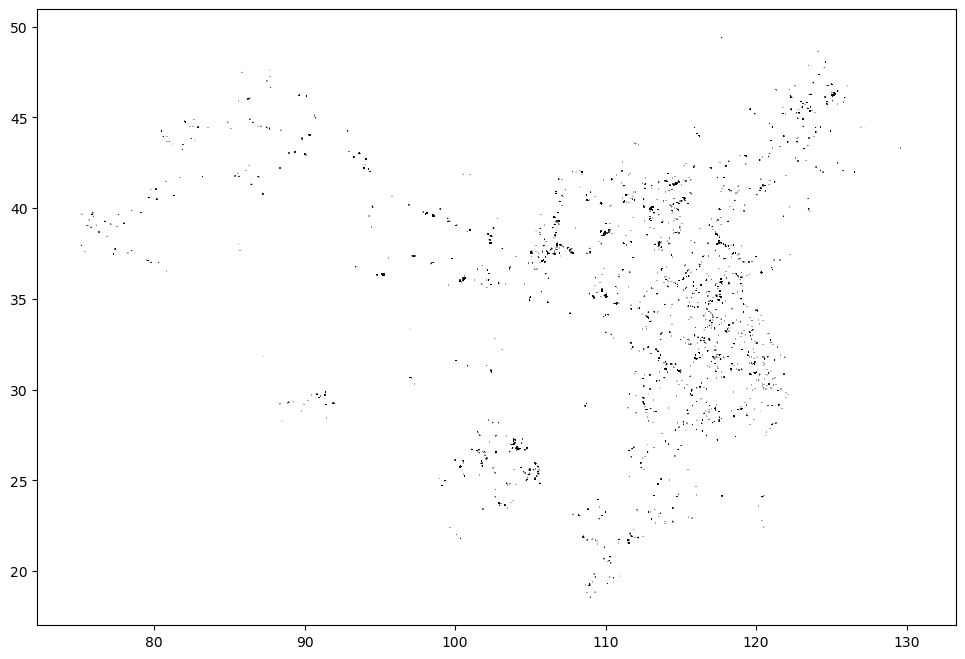

In [11]:
gdf.plot(figsize=(12, 8), edgecolor="black", linewidth=0.5)
